In [115]:
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [116]:
train = pd.read_csv("data/train_clean.csv", index_col="id", parse_dates=["timestamp"])
test = pd.read_csv("data/test_clean.csv", index_col="id", parse_dates=["timestamp"])
macro = pd.read_csv("data/macro.csv", parse_dates=["timestamp"])

In [118]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc"], axis=1)

# transform non-numerical variables
for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

y_train = y_train.astype(np.float32)
x_train = x_train.astype(np.float32)

In [119]:
x_test = test.drop(["timestamp"], axis=1)

# transform non-numerical variables
for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        
x_test = x_test.astype(np.float32)

In [120]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [121]:
dtrain = xgb.DMatrix(x_train, y_train)

In [122]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.10399e+06	test-rmse:8.10768e+06
[50]	train-rmse:2.45936e+06	test-rmse:2.81315e+06
[100]	train-rmse:2.1527e+06	test-rmse:2.64913e+06
[150]	train-rmse:2.04796e+06	test-rmse:2.62117e+06
[200]	train-rmse:1.9689e+06	test-rmse:2.60674e+06
[250]	train-rmse:1.89894e+06	test-rmse:2.59726e+06
[300]	train-rmse:1.84237e+06	test-rmse:2.59327e+06
[350]	train-rmse:1.78946e+06	test-rmse:2.59036e+06


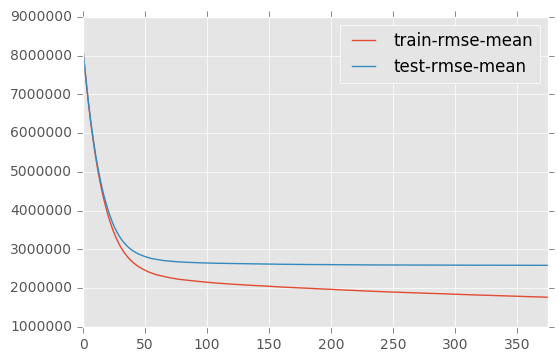

In [123]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [124]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

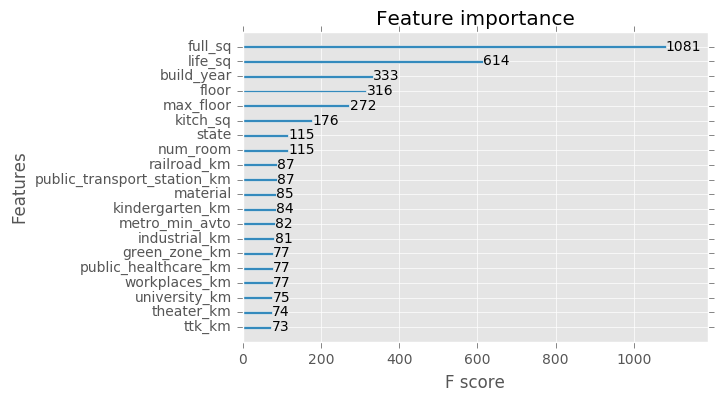

In [125]:
xgb.plot_importance(model, max_num_features=20)

In [126]:
pred = model.predict(dtrain)

In [127]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [128]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

In [129]:
print("RMSLE: {rmsle}, Error: {error}".format(rmsle=rmsle, error=error))

RMSLE: 12827.783868865585, Error: 41.1671609211396


In [130]:
dtest = xgb.DMatrix(x_test)

In [131]:
y_predict = model.predict(dtest)

In [98]:
output = pd.DataFrame({"id": x_test.index, "price_doc": y_predict})

In [99]:
output.to_csv("submissions_clean_{}.csv".format(datetime.datetime.today()), index=False)

### Correction

In [185]:
# train prices are round values for investment type
# idea: take price_doc that are close to the prices in train and take this value
train[["price_doc", "product_type"]][train.product_type == "Investment"].price_doc.value_counts(dropna=False).head(10)

2000000    750
1000000    743
6000000    369
3000000    329
6500000    327
7000000    319
5500000    309
6300000    292
5000000    292
7500000    275
Name: price_doc, dtype: int64

In [190]:
investment_prices = train[["price_doc", "product_type"]][train.product_type == "Investment"].price_doc.values
unique_investment_prices = set(investment_prices)

In [181]:
output_cor = pd.DataFrame({"id": test.index, "product_type": test.product_type, "price_doc": y_predict})

In [212]:
def correct_investment_price(price):
    return min(unique_investment_prices, key=lambda x: abs(x - price))

In [218]:
output_cor["price_doc_cor"] = output_cor[output_cor.product_type == "Investment"].apply(lambda x: correct_investment_price(x.price_doc), axis=1)

In [232]:
def take_price_doc_corr(x):
    if x.product_type == "Investment":
        return x.price_doc_cor
    else:
        return x.price_doc

In [236]:
output_final = output_cor.apply(lambda x: take_price_doc_corr(x), axis=1).reset_index(name="price_doc")

In [238]:
output_final.head()

,id,price_doc
0,30474,5580000.0
1,30475,8270271.5
2,30476,5330000.0
3,30477,6041688.5
4,30478,5216716.0


In [246]:
output_final.to_csv("submissions_corrected_{}.csv".format(datetime.datetime.today()), index=False)